### Import Required Packages

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

### Constant Variables

In [130]:
DATASET_PATH = './Data/dataset.csv'
COLUMNS_TO_DROP = [
    'Timestamp',
    'Affiliations',
    'Platforms Used',
]

### Data Cleaning

#### Load the dataset

In [131]:
df = pd.read_csv(DATASET_PATH)

#### Rename the columns for data analysis

In [132]:

df.rename(columns={'1. What is your age?': 'Age', '2. Gender': 'Gender', '3. Relationship Status': 'Relationship Status',
                   '4. Occupation Status': 'Occupation',
                   '5. What type of organizations are you affiliated with?': 'Affiliations',
                   '6. Do you use social media?': 'Social Media User?',
                   '7. What social media platforms do you commonly use?': 'Platforms Used',
                   '8. What is the average time you spend on social media every day?': 'Hours Per Day',
                   '9. How often do you find yourself using Social media without a specific purpose?': 'ADHD Q1',
                   '10. How often do you get distracted by Social media when you are busy doing something?': 'ADHD Q2',
                   "11. Do you feel restless if you haven't used Social media in a while?": 'Anxiety Q1',
                   '12. On a scale of 1 to 5, how easily distracted are you?': 'ADHD Q3',
                   '13. On a scale of 1 to 5, how much are you bothered by worries?': 'Anxiety Q2',
                   '14. Do you find it difficult to concentrate on things?': 'ADHD Q4',
                   '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?': 'Self Esteem Q1',
                   '16. Following the previous question, how do you feel about these comparisons, generally speaking?': 'Self Esteem Q2',
                   '17. How often do you look to seek validation from features of social media?': 'Self Esteem Q3',
                   '18. How often do you feel depressed or down?': 'Depression Q1',
                   '19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?': 'Depression Q2',
                   '20. On a scale of 1 to 5, how often do you face issues regarding sleep?': 'Depression Q3'}, inplace=True)
df.drop(COLUMNS_TO_DROP, inplace=True, axis=1)

#### Unify the gender category and convert age type

In [133]:

df.replace('Non-binary', 'Non-Binary', inplace=True)
df.replace('Nonbinary ', 'Non-Binary', inplace=True)
df.replace('NB', 'Non-Binary', inplace=True)
df.replace('Non binary ', 'Non-Binary', inplace=True)

df['Age'] = df['Age'].astype('int64')

#### Calculate ADHD and Depression Score

In [134]:

df.loc[df['Self Esteem Q2'] == 1, 'Self Esteem Q2'] = 5
df.loc[df['Self Esteem Q2'] == 2, 'Self Esteem Q2'] = 4
df.loc[df['Self Esteem Q2'] == 3, 'Self Esteem Q2'] = 3
df.loc[df['Self Esteem Q2'] == 4, 'Self Esteem Q2'] = 2
df.loc[df['Self Esteem Q2'] == 5, 'Self Esteem Q2'] = 1

ADHD = ['ADHD Q1', 'ADHD Q2', 'ADHD Q3', 'ADHD Q4']
df['ADHD Score'] = df[ADHD].sum(axis=1)

Anxiety = ['Anxiety Q1', 'Anxiety Q2']
df['Anxiety Score'] = df[Anxiety].sum(axis=1)

SelfEsteem = ['Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3']
df['Self Esteem Score'] = df[SelfEsteem].sum(axis=1)

Depression = ['Depression Q1', 'Depression Q2', 'Depression Q3']
df['Depression Score'] = df[Depression].sum(axis=1)

Total = ['ADHD Score', 'Anxiety Score',
         'Self Esteem Score', 'Depression Score']
df['Total Score'] = df[Total].sum(axis=1)

# Deleting question columns and timestamp columns as they are no longer used
df.drop(columns=ADHD + Anxiety + SelfEsteem + Depression, inplace=True)

#### Convert usage time into integer

In [135]:

df.loc[df['Hours Per Day'] == 'More than 5 hours', 'Hours Per Day'] = 5.5
df.loc[df['Hours Per Day'] == 'Between 2 and 3 hours', 'Hours Per Day'] = 2.5
df.loc[df['Hours Per Day'] == 'Between 3 and 4 hours', 'Hours Per Day'] = 3.5
df.loc[df['Hours Per Day'] == 'Between 1 and 2 hours', 'Hours Per Day'] = 1.5
df.loc[df['Hours Per Day'] == 'Between 4 and 5 hours', 'Hours Per Day'] = 4.5
df.loc[df['Hours Per Day'] == 'Less than an Hour', 'Hours Per Day'] = 0.5

# Since the user indicated that they do not use social media but provided platforms to use, this is assumed to be a typo
df.loc[df['Social Media User?'] == 'No', 'Social Media User?'] = 'Yes'

# since the person who answered 91 also answered that they are college student, we assumed that this was a typo
df.loc[df['Age'] == 91, 'Age'] = 19

#### Map Categorical Values to Numerical Values

In [136]:
df.loc[df['Relationship Status'] ==
       'In a relationship', 'Relationship Status'] = 1
df.loc[df['Relationship Status'] == 'Single', 'Relationship Status'] = 2
df.loc[df['Relationship Status'] == 'Married', 'Relationship Status'] = 3
df.loc[df['Relationship Status'] == 'Divorced', 'Relationship Status'] = 4
df['Relationship Status'] = df['Relationship Status'].astype('int64')

df.loc[df['Occupation'] ==
       'University Student', 'Occupation'] = 1
df.loc[df['Occupation'] ==
       'School Student', 'Occupation'] = 2
df.loc[df['Occupation'] ==
       'Salaried Worker', 'Occupation'] = 3
df.loc[df['Occupation'] ==
       'Retired', 'Occupation'] = 4
df['Occupation'] = df['Occupation'].astype('int64')

### Final Dataset

In [137]:
df.head()

,Age,Gender,Relationship Status,Occupation,Social Media User?,Hours Per Day,ADHD Score,Anxiety Score,Self Esteem Score,Depression Score,Total Score
0,21,Male,1,1,Yes,2.5,18,4,7,14,43
1,21,Female,2,1,Yes,5.5,15,7,7,14,43
2,21,Female,2,1,Yes,3.5,11,6,7,11,35
3,21,Female,2,1,Yes,5.5,12,6,8,9,35
4,21,Female,2,1,Yes,2.5,17,9,9,9,44


### Data Statistics

#### Data Distribution

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Relationship Status'}>,
        <Axes: title={'center': 'Occupation'}>],
       [<Axes: title={'center': 'ADHD Score'}>,
        <Axes: title={'center': 'Anxiety Score'}>,
        <Axes: title={'center': 'Self Esteem Score'}>],
       [<Axes: title={'center': 'Depression Score'}>,
        <Axes: title={'center': 'Total Score'}>, <Axes: >]], dtype=object)

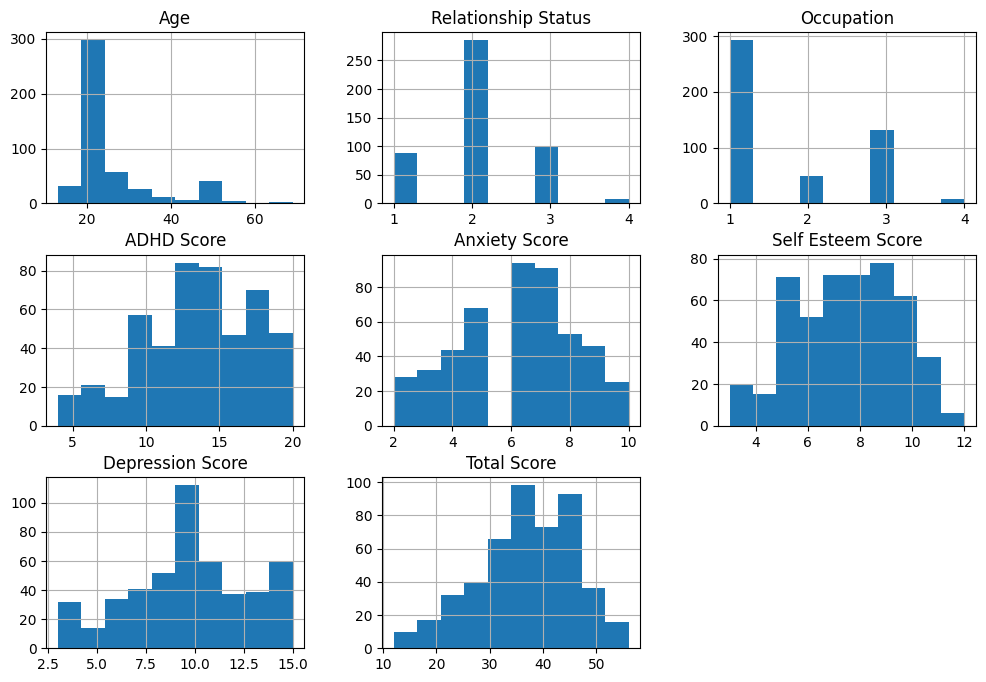

In [138]:
df.hist(figsize=(12, 8))